## 1 환경설정

In [301]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:80% !important;}</style>"))
%matplotlib inline

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
import folium
import folium.plugins
import requests
import json
import folium.plugins
from IPython.display import Image
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (12,8)  #시각화 figure default 설정
mpl.rcParams['font.family'] = 'Malgun Gothic' #폰트 디폴트 설정
mpl.rcParams['font.size'] = 10    #폰트 사이즈 디폴트 설정
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format='retina' # 그래프 글씨 뚜렷
pd.options.display.float_format = '{:.1f}'.format # 넘파이 과학적 표기 제거

In [302]:
import matplotlib.font_manager as fm

gothic_list = [font for font in fm.get_font_names() if 'Gothic' in font]
print(gothic_list)

['Malgun Gothic', 'MS Gothic', 'Franklin Gothic Medium', 'Yu Gothic']


In [303]:
# 부산 행정구역 json raw파일(githubcontent)
r = requests.get('https://raw.githubusercontent.com/raqoon886/Local_HangJeongDong/master/hangjeongdong_%EB%B6%80%EC%82%B0%EA%B4%91%EC%97%AD%EC%8B%9C.geojson')
c = r.content
busan_geo = json.loads(c)

## 2 데이터 분석

### 2.1 부산광역시_지역구별_업종별_소비

In [304]:
# url = 'http://apis.data.go.kr/6260000/AttractionService/getAttractionKr'
# params ={'serviceKey' : 'BQLLeF2hdIs7v4c0bchpT0YyP005ULdW6/wUX8rg70BY/c940AN5ss1zHbXpjWzvUCX8ZkiG0u4dfP9H39jGpA==', 
#          'numOfRows' : '4000', 
#          'pageNo' : '1',
#          'resultType' : 'json' }

# response = requests.get(url, params=params)
# contents = response.content

In [305]:
# json_attraction = json.loads(contents)
# json_attraction

# body = json_attraction['getAttractionKr']['item']
# df_busan_attraction = pd.json_normalize(body)
# df_busan_attraction.head(1)

In [306]:
import os

path = "./"
file_list = os.listdir(path)
csv_list = [file for file in file_list if file.endswith(".csv")]
csv_list

['부산광역시_지역구별_대분류중분류_지출액.csv',
 '부산시_22년월별_중분류별_지출액.csv',
 '부산시_당해전년_소비액.csv',
 '부산시_대분류중분류별_지출액.csv',
 '부산시_지역구별_당해전년_소비액.csv',
 '부산시_지역구별_지출액.csv']

In [307]:
df_spend = pd.read_csv("부산시_22년월별_중분류별_지출액.csv", encoding = "cp949")
df_spend["전년 동월 대비 증감액"] = (df_spend["지출액"] - df_spend["전년도 지출액"]) / df_spend["전년도 지출액"] * 100
df_spend['기준년월'] = pd.to_datetime(df_spend['기준년월'].astype(str), format='%Y%m')
df_time = df_spend.groupby(['중분류', '기준년월'])['지출액'].sum().to_frame().reset_index()

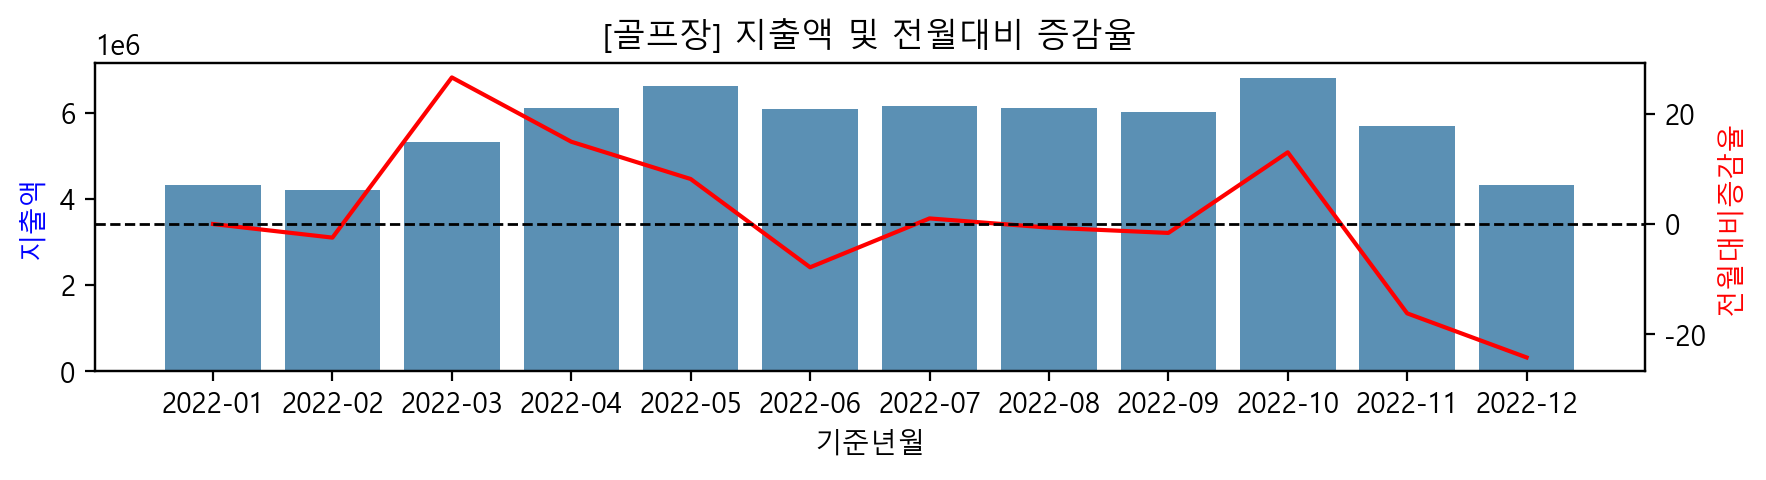

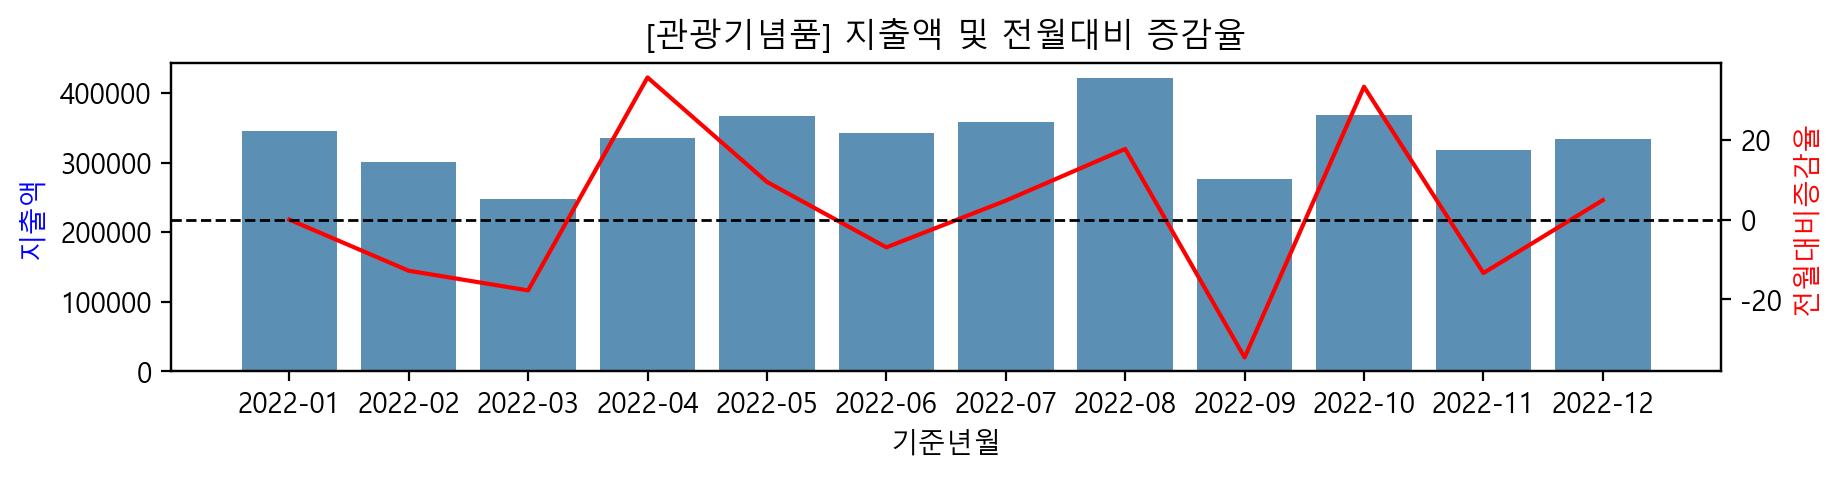

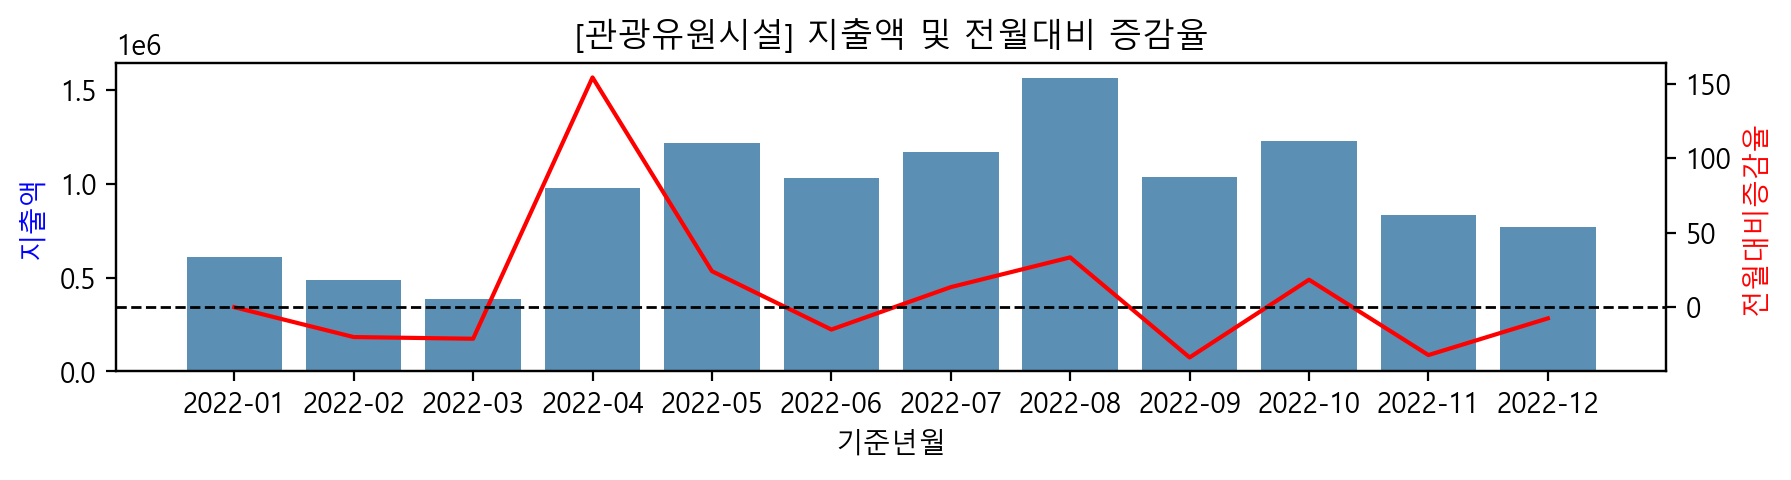

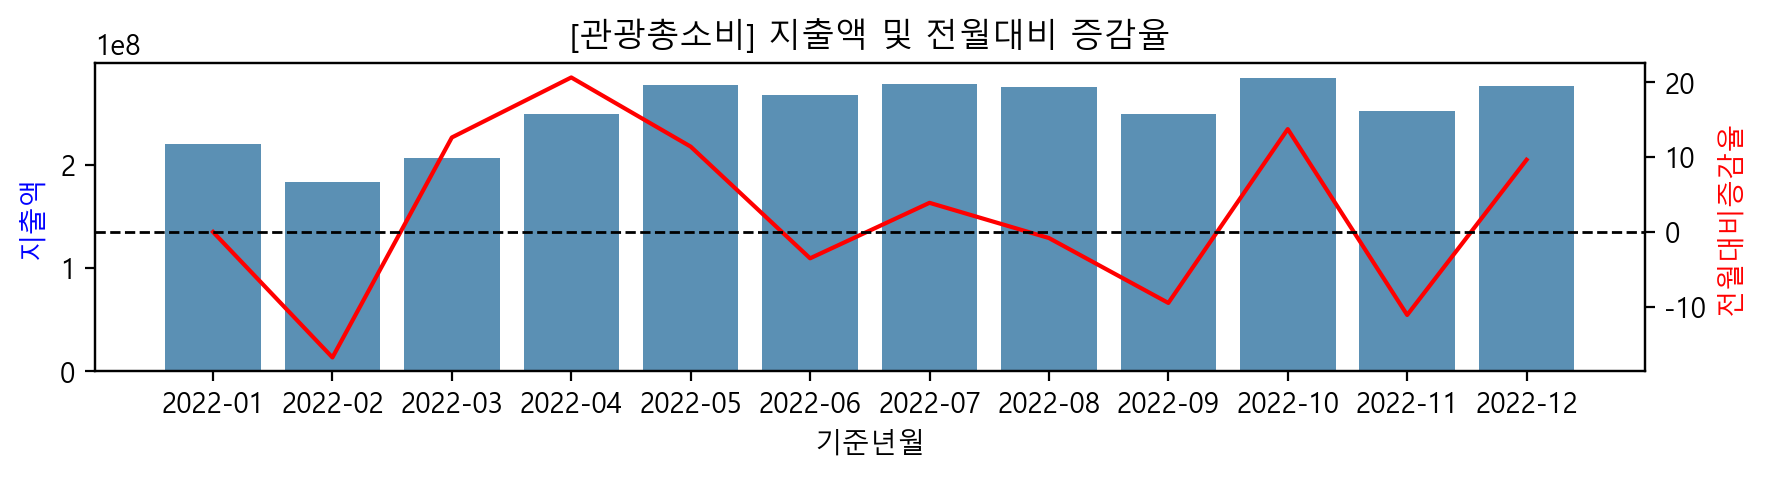

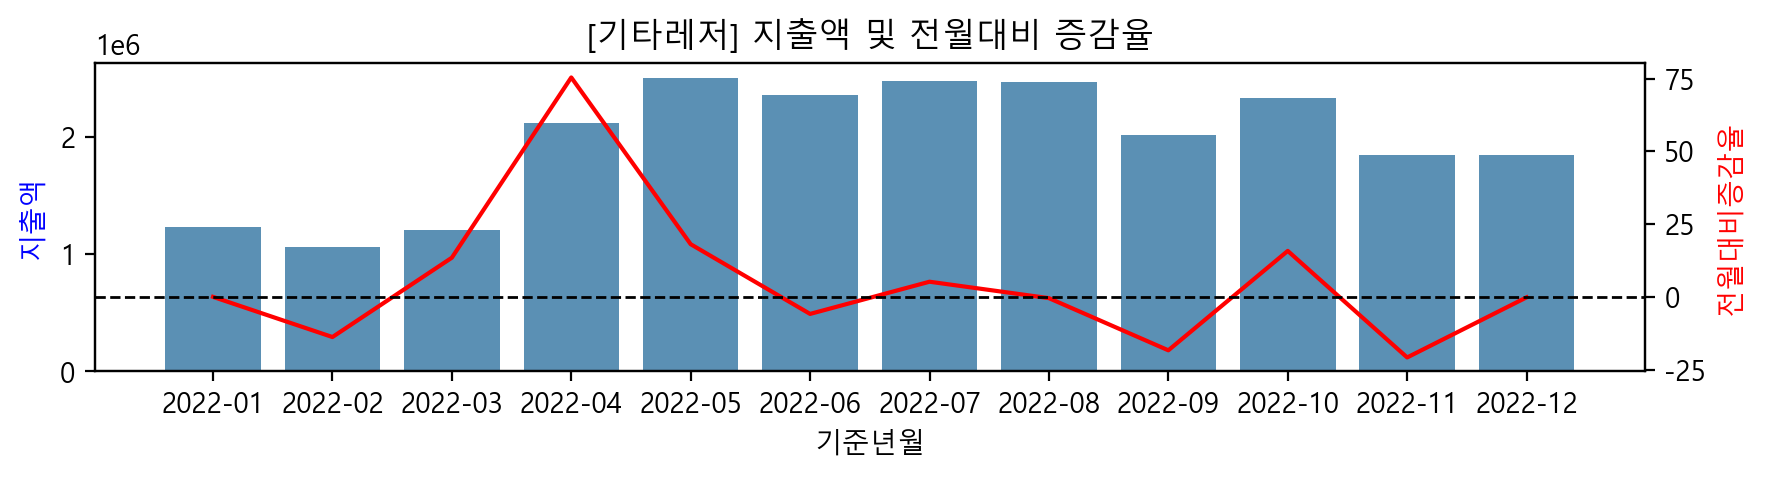

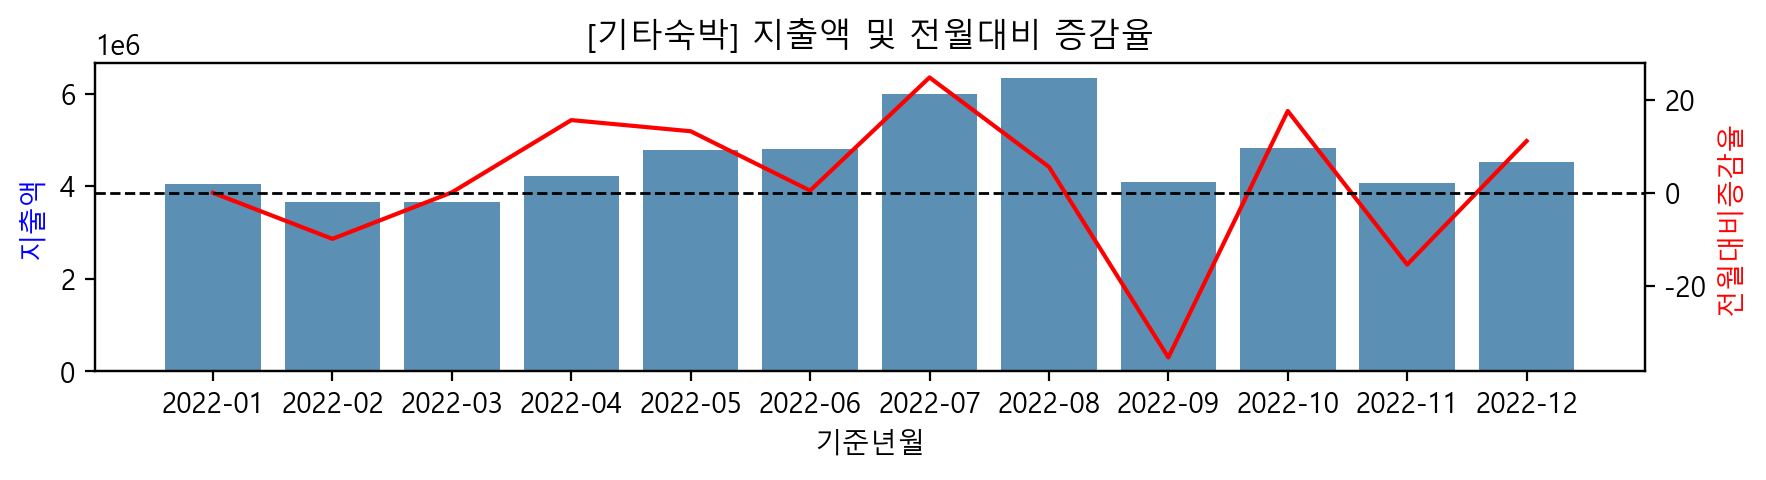

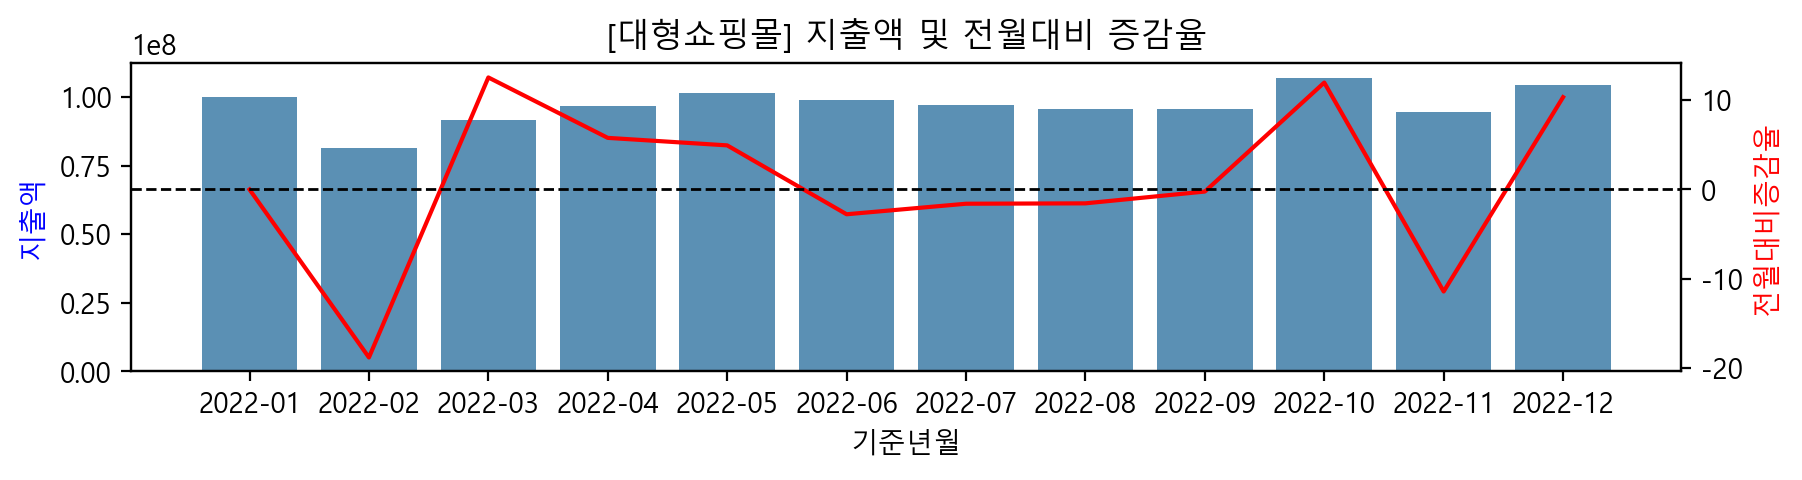

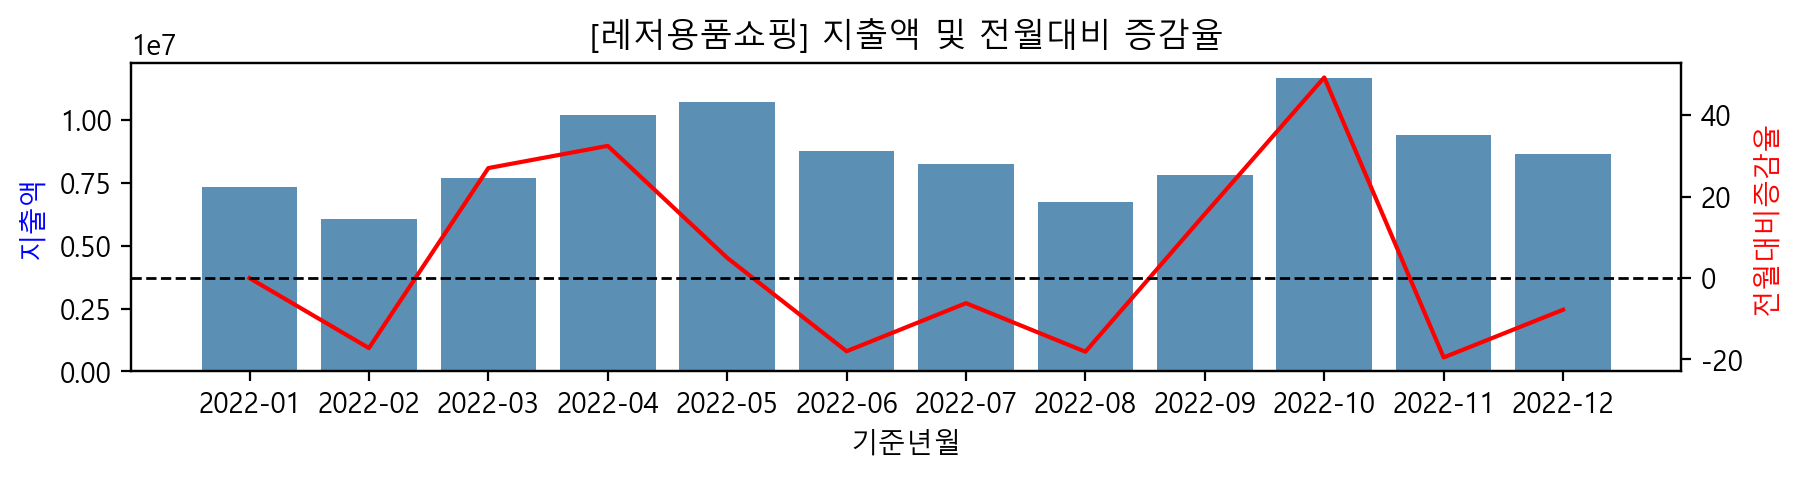

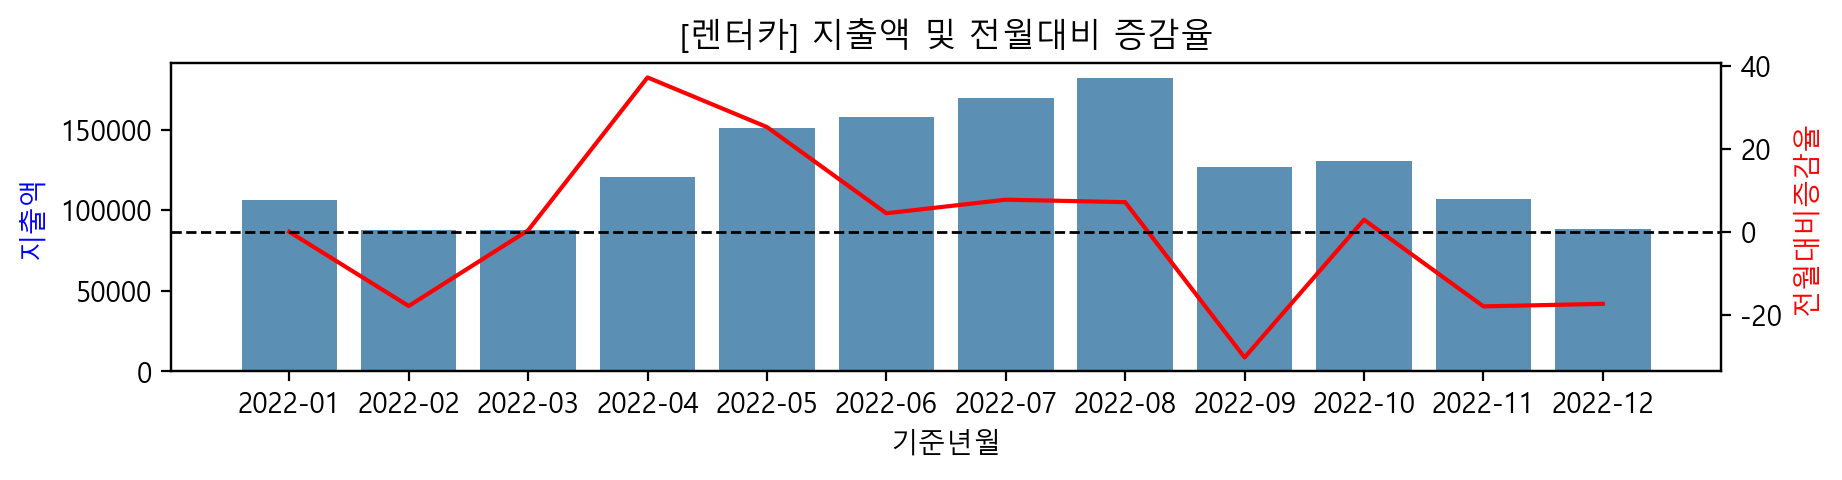

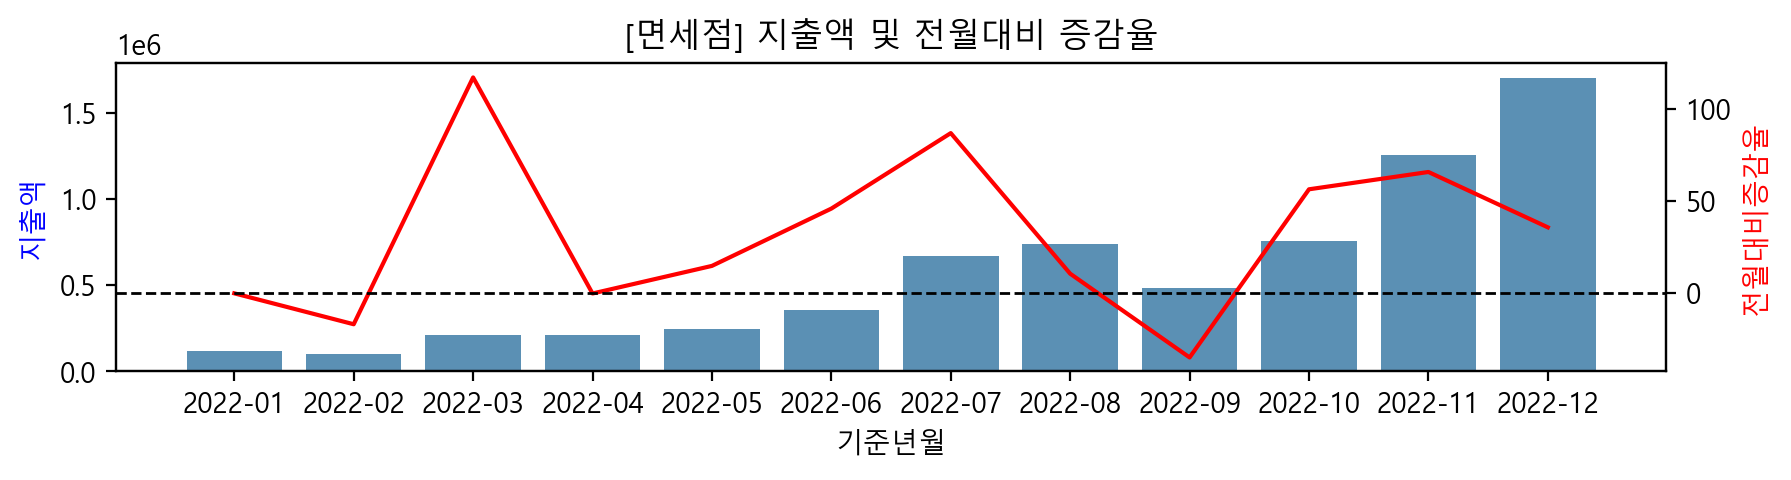

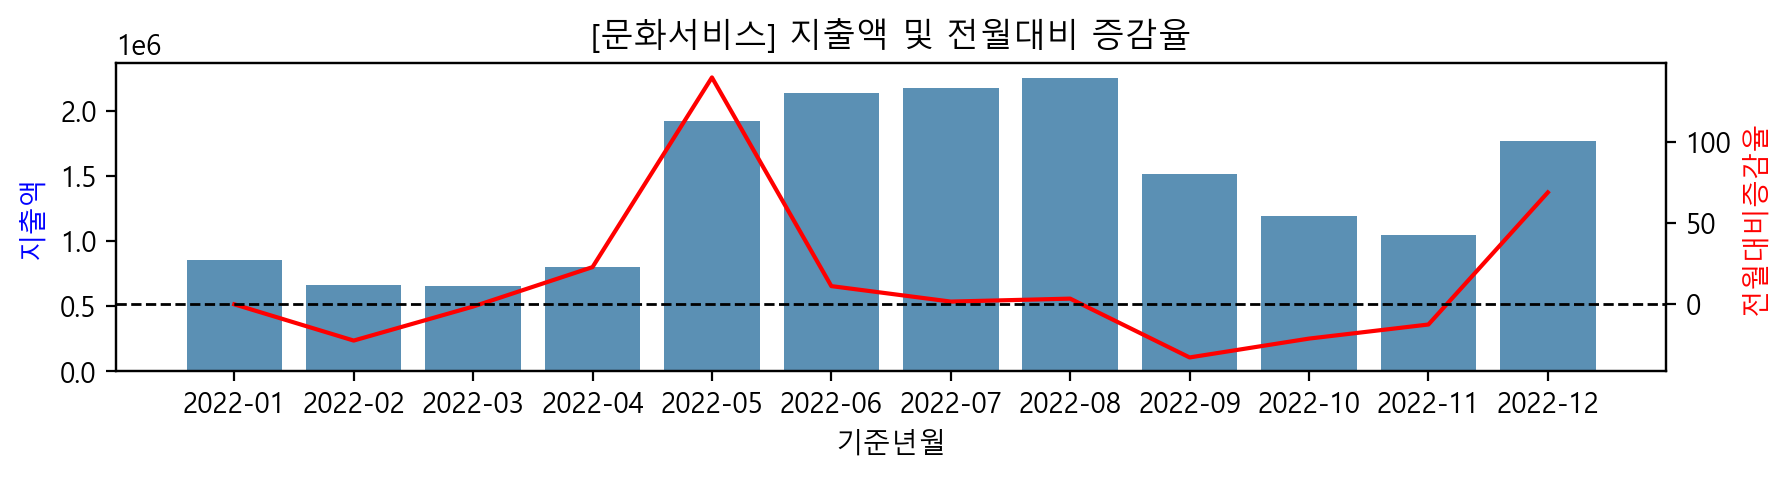

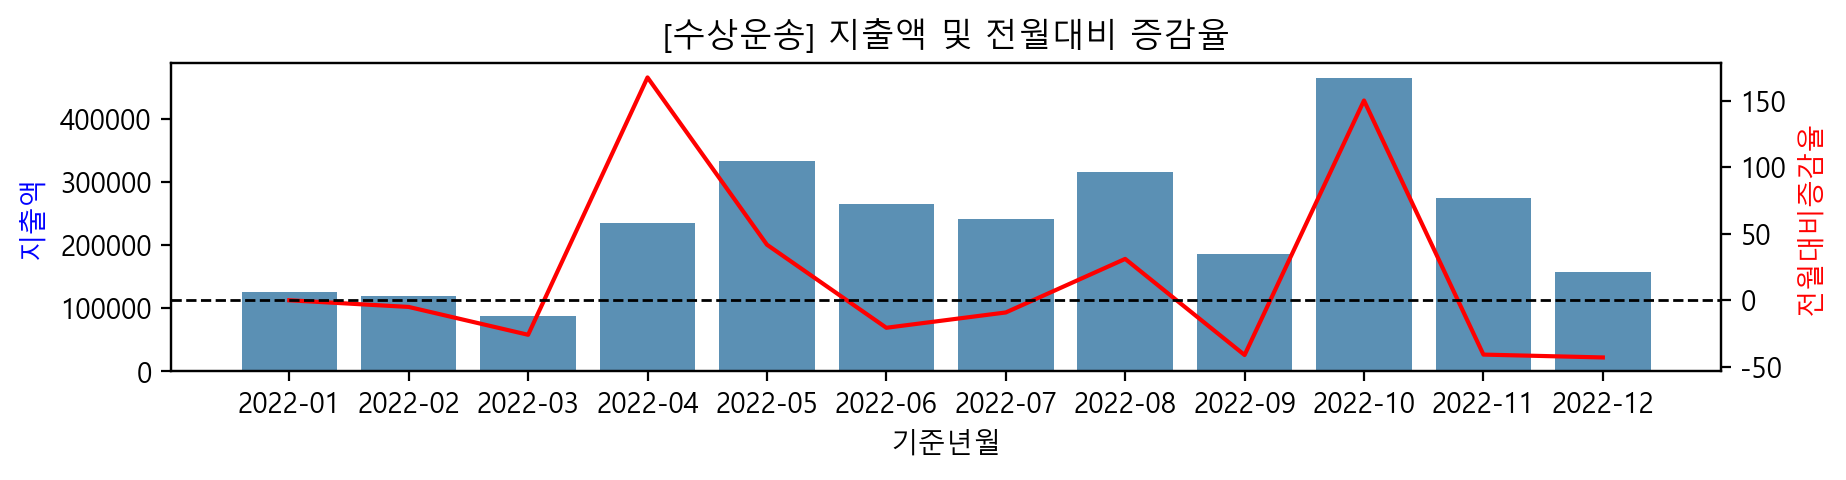

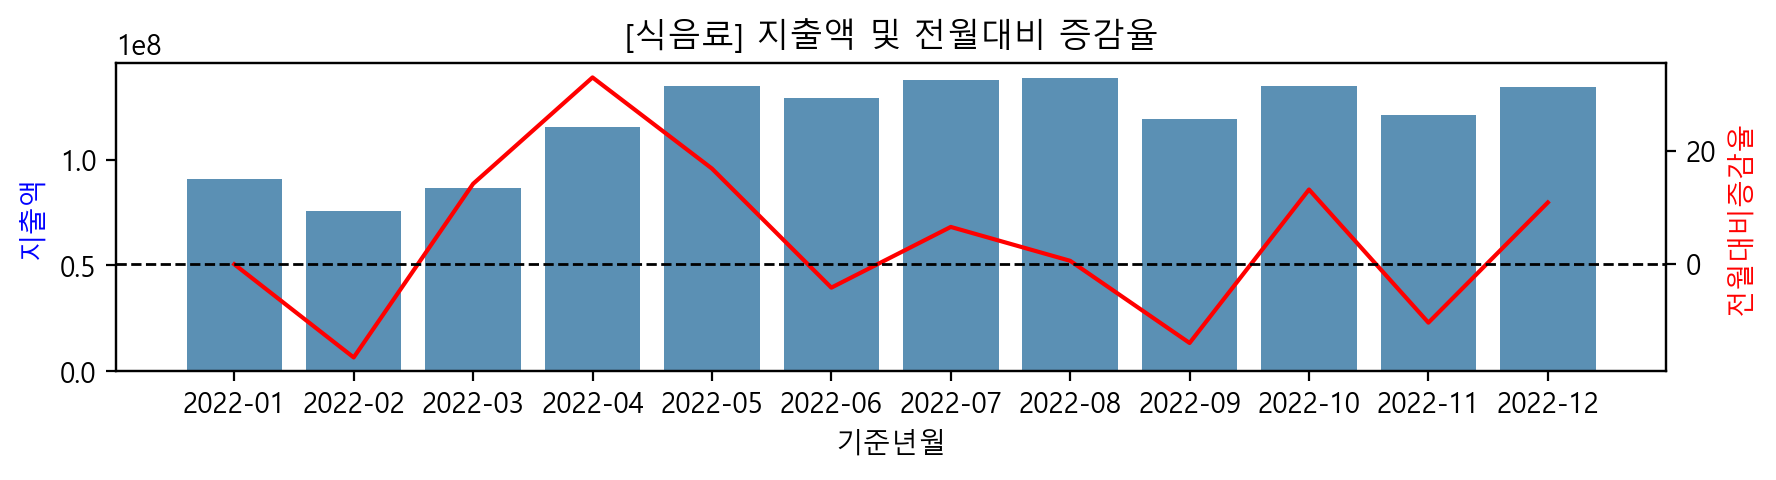

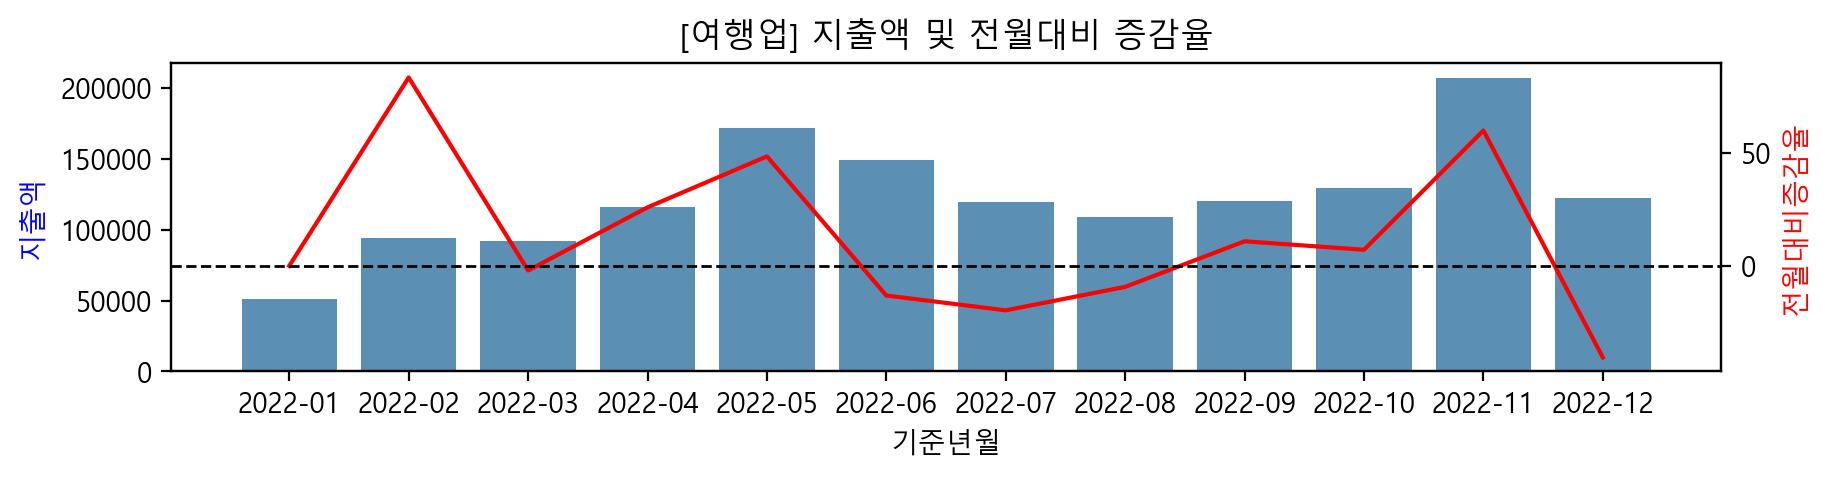

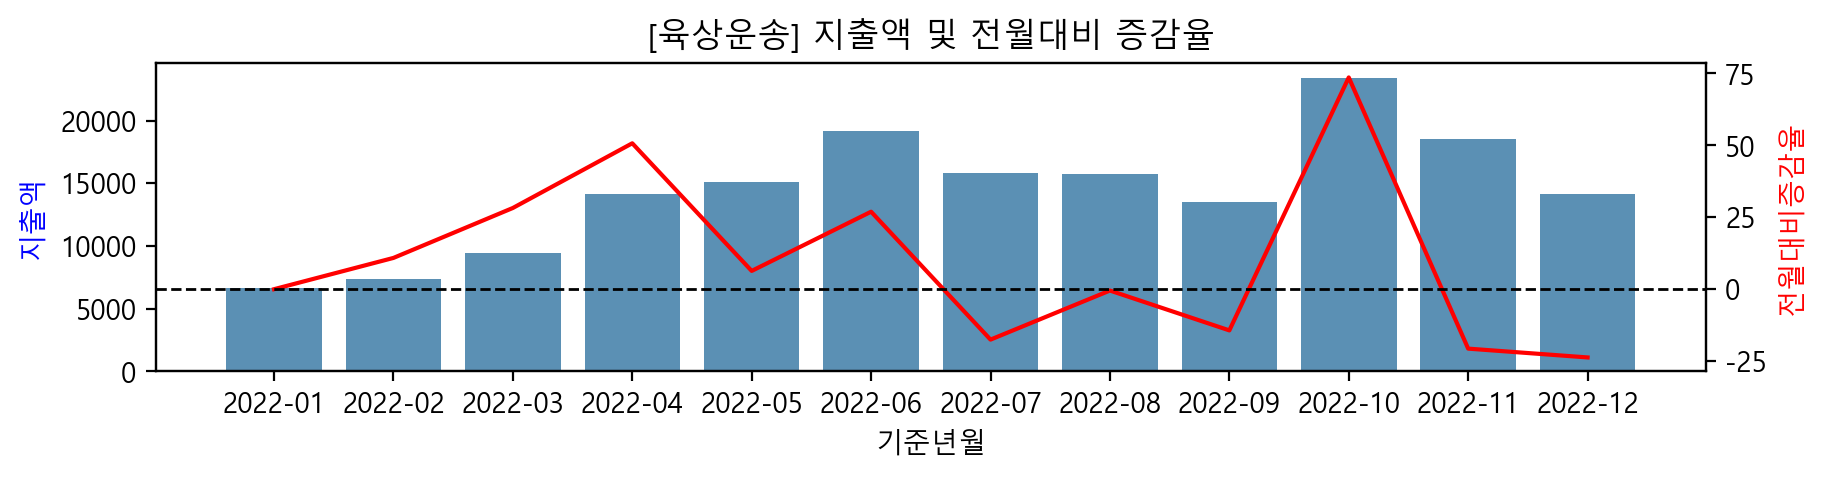

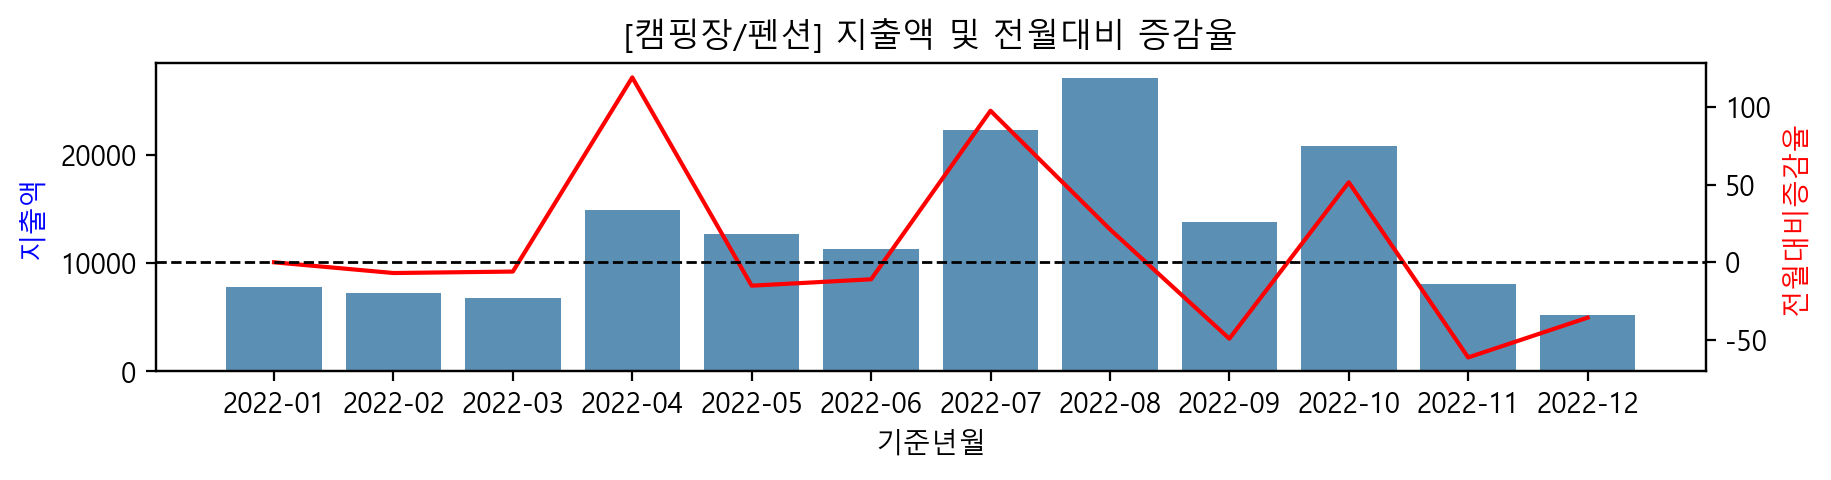

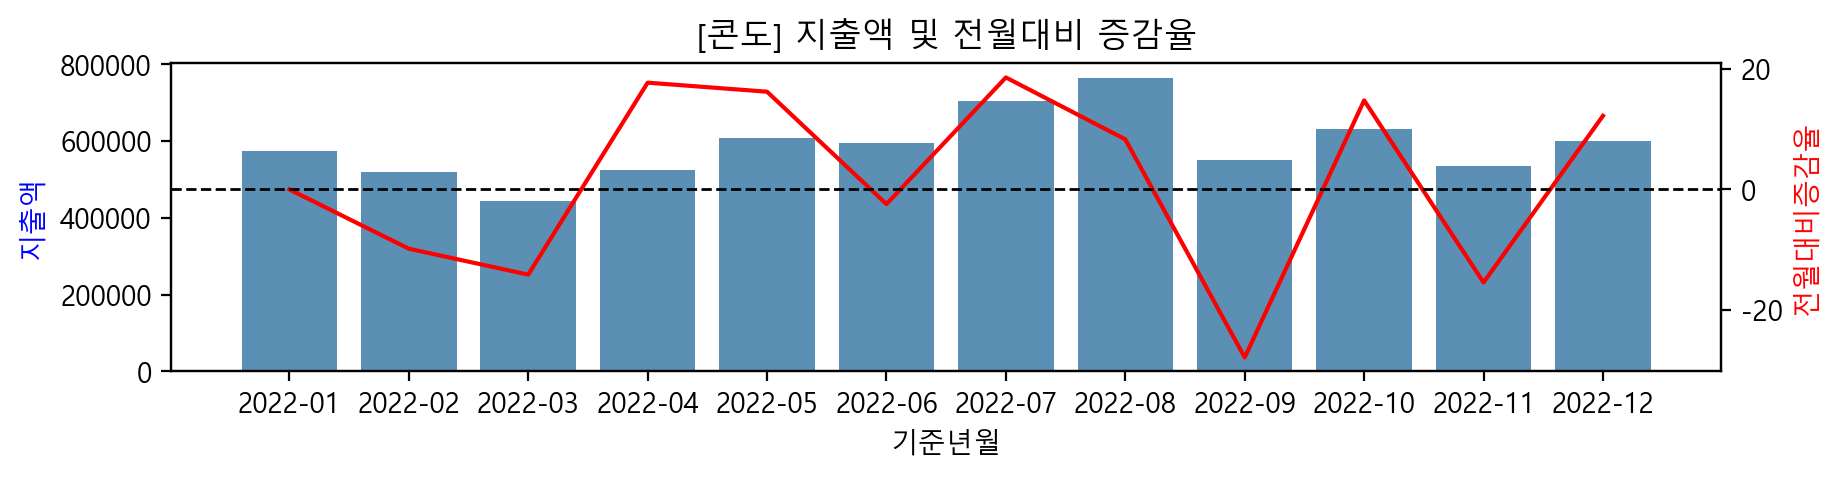

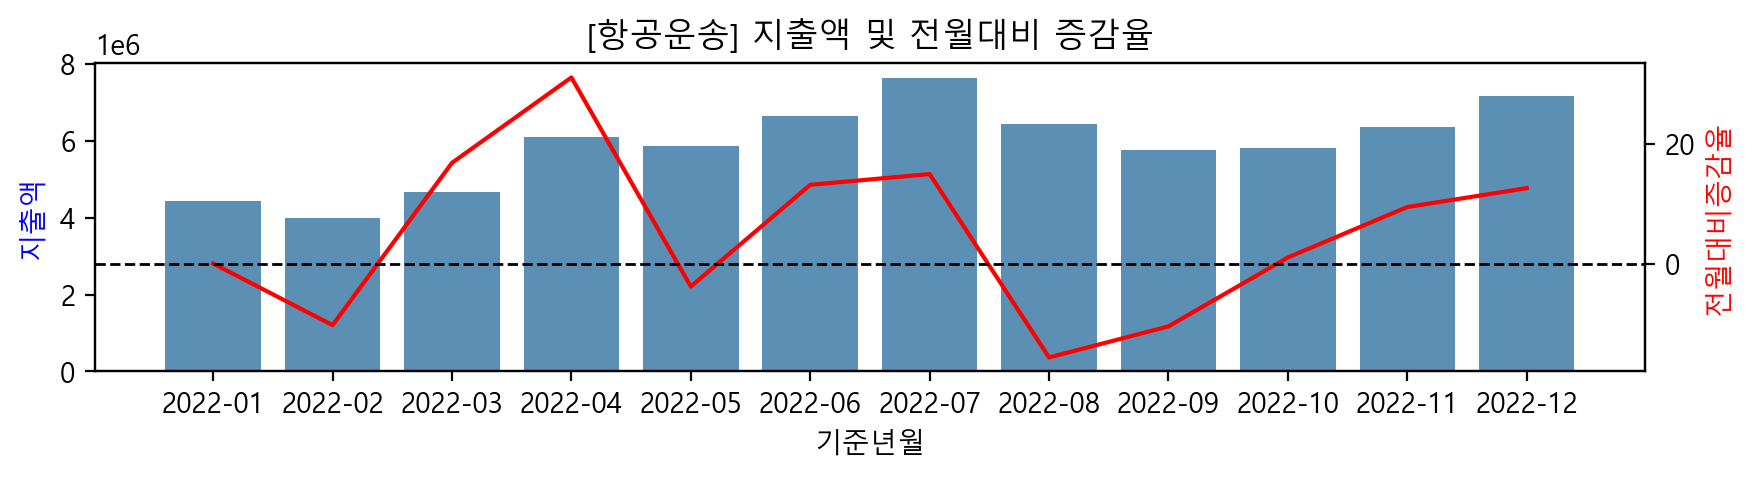

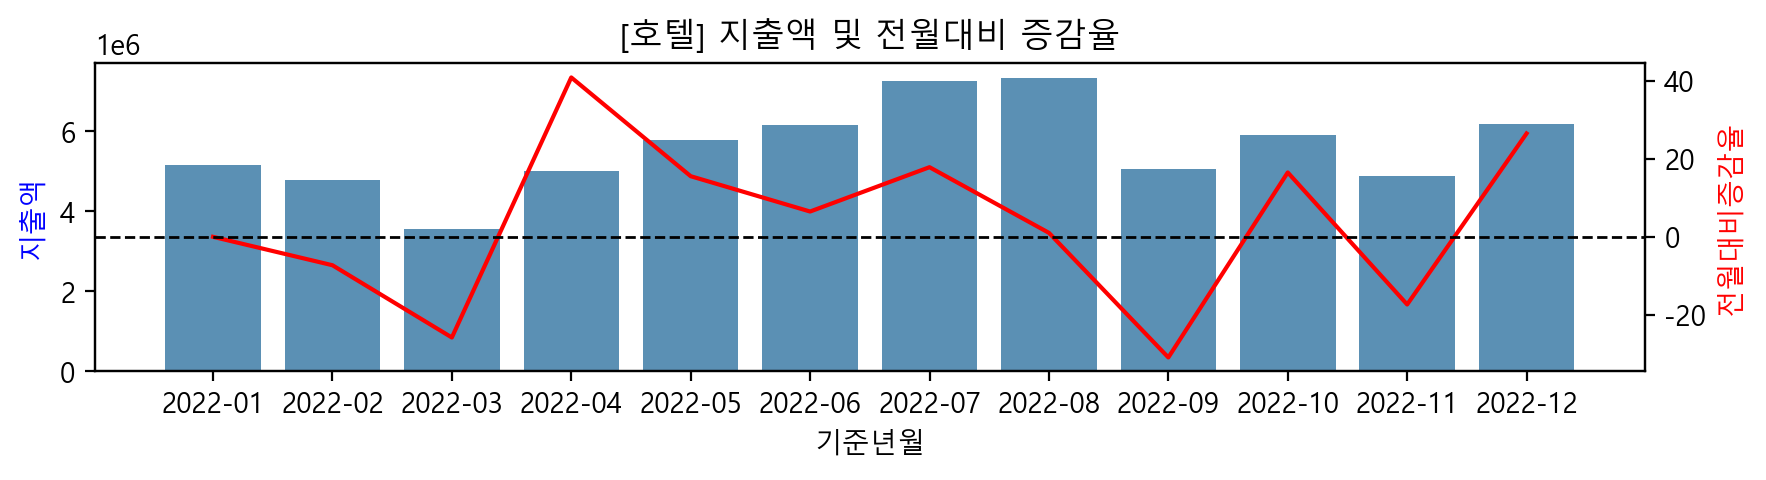

In [308]:
for standard in df_time['중분류'].unique():
    tmp = df_time.loc[df_time['중분류'] == standard,:].copy()
    tmp['전월지출액'] = tmp['지출액'].shift()
    tmp['전월대비증감율'] = ((tmp['지출액'] - tmp['전월지출액']) / tmp['전월지출액']) * 100
    tmp['기준년월'] = tmp['기준년월'].dt.strftime('%Y-%m')
    tmp.fillna(0, inplace=True)
    # print(tmp['기준년월'])
    
    fig, ax1 = plt.subplots(1,1, figsize = (10,2))
    ax2 = ax1.twinx()

    sns.barplot(data = tmp, x = '기준년월', y = '지출액', ax = ax1, alpha = 0.8)
    sns.lineplot(data = tmp, x = '기준년월', y = '전월대비증감율', ax = ax2, color = 'red')

    # y축 범위 설정 (전월대비증감율을 -20 ~ 20 사이로 설정, 0이 중심이 되도록)
    # ax2.set_ylim(-20, 20)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)  # 0 기준선 추가
    # 라벨 설정
    ax1.set_xlabel('기준년월')
    ax1.set_ylabel('지출액', color='blue')
    ax2.set_ylabel('전월대비증감율', color='red')
    ax1.set_title(f'[{standard}] 지출액 및 전월대비 증감율')

In [309]:
df_category_spend = df_spend.groupby("중분류")[["지출액", "전년도 지출액"]].sum()
df_category_spend["전년대비증감율"] = (df_category_spend["지출액"] - df_category_spend["전년도 지출액"]) / df_category_spend["전년도 지출액"] * 100
df_category_spend.sort_values(by='지출액', ascending = False, inplace=True)
df_category_spend.reset_index(drop = False, inplace=True)
total_spend = df_category_spend.loc[df_category_spend['중분류'] == '관광총소비', '지출액'].values
df_category_spend['지출 비율'] = (df_category_spend['지출액'] / total_spend) * 100
df_category_spend = df_category_spend.iloc[1:,:]
df_category_spend

,중분류,지출액,전년도 지출액,전년대비증감율,지출 비율
1,식음료,1417281900.0,1095584772.0,29.4,46.9
2,대형쇼핑몰,1164980018.0,1000870004.0,16.4,38.5
3,레저용품쇼핑,103373259.0,95921925.0,7.8,3.4
4,항공운송,70897368.0,27307221.0,159.6,2.3
5,골프장,67906916.0,60977082.0,11.4,2.2
6,호텔,67090689.0,51454158.0,30.4,2.2
7,기타숙박,55067069.0,44214877.0,24.5,1.8
8,기타레저,23441133.0,15407998.0,52.1,0.8
9,문화서비스,17011187.0,10564494.0,61.0,0.6
10,관광유원시설,11303887.0,5509785.0,105.2,0.4


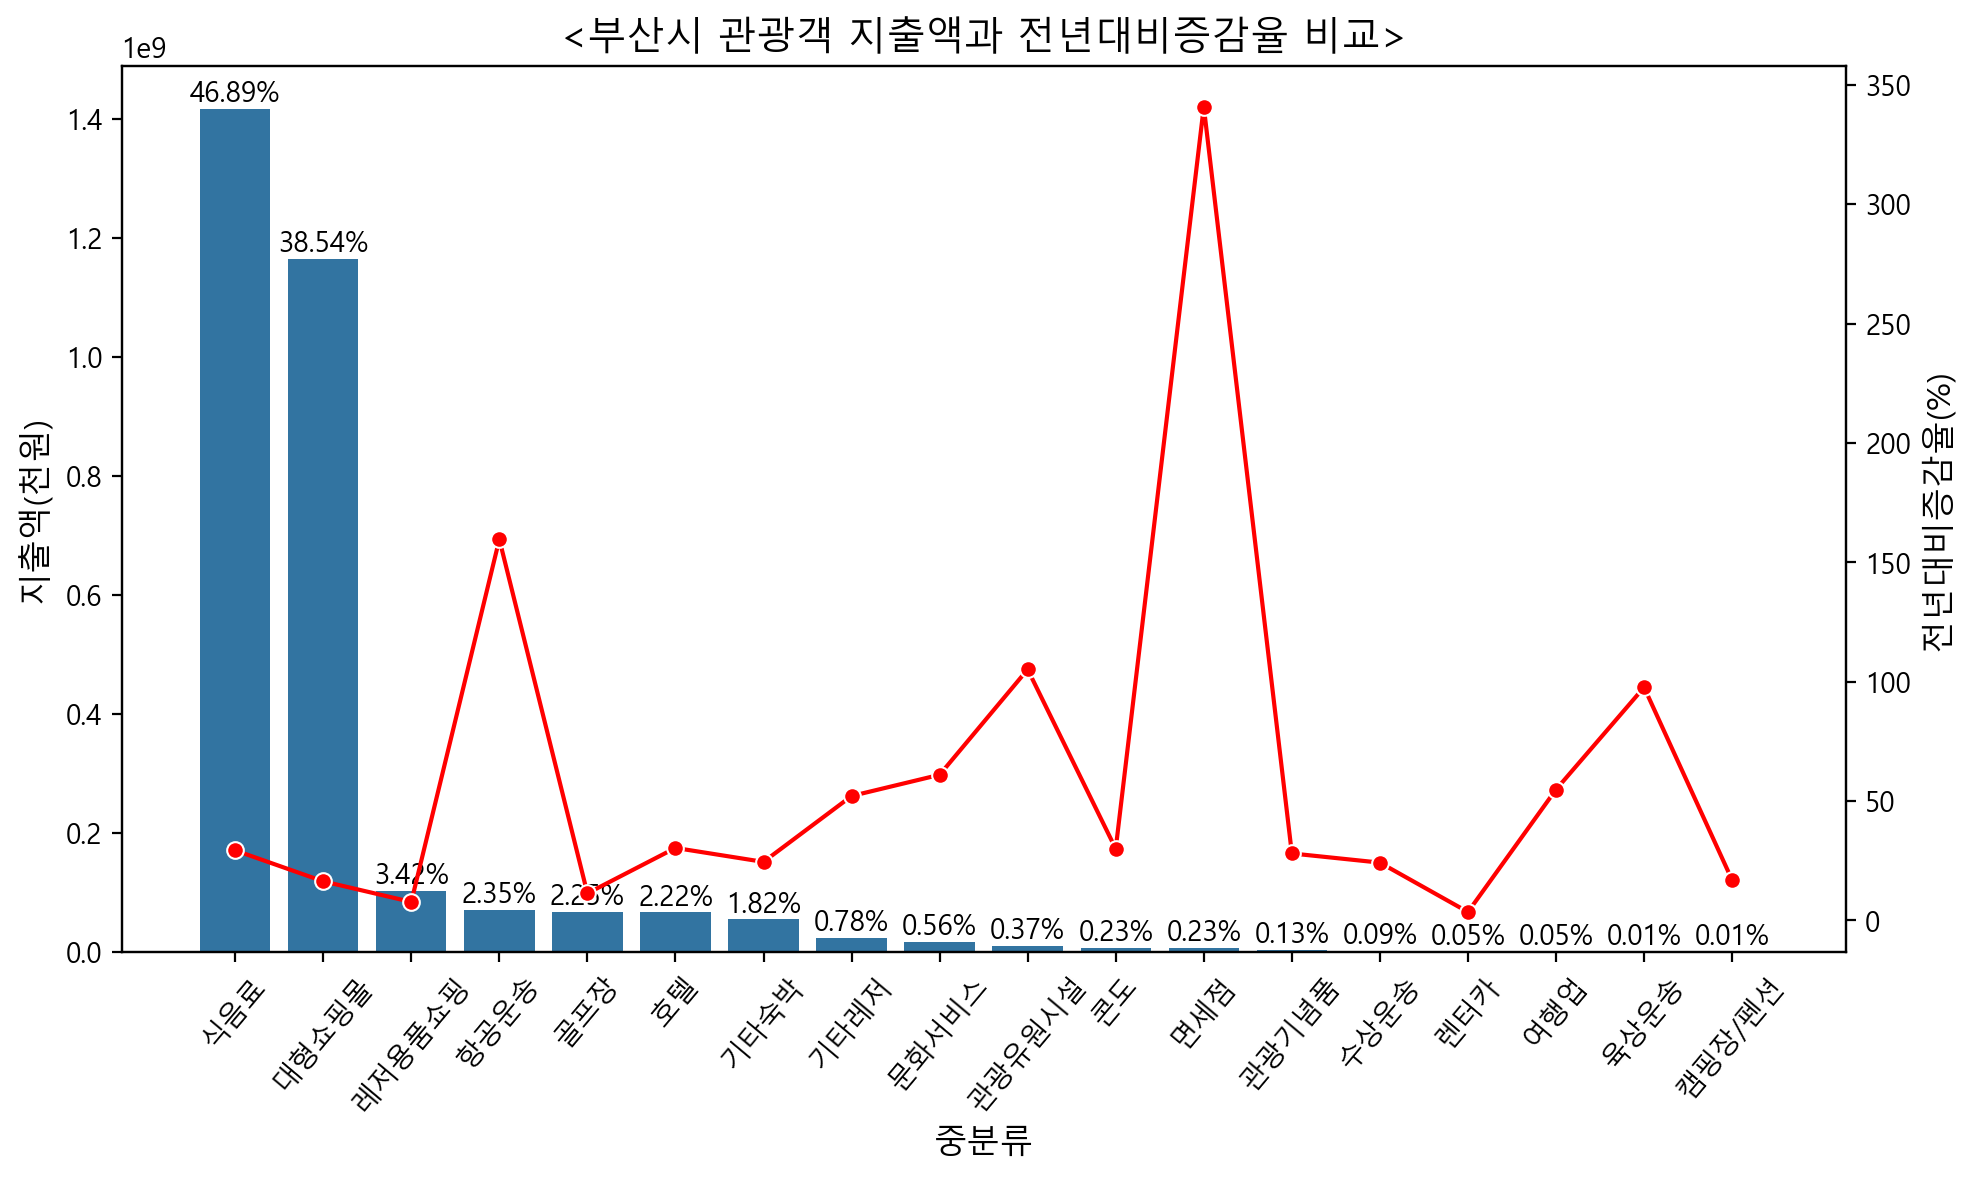

In [310]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bar_container = sns.barplot(
    y = df_category_spend['지출액'],
    x = df_category_spend['중분류'],
    ax = ax
)

ax2 = ax.twinx()

sns.lineplot(
    y = df_category_spend['전년대비증감율'],
    x = df_category_spend['중분류'],
    ax = ax2,
    color='red',
    marker='o'
)

ax.set_ylabel('지출액(천원)', fontsize=12)
ax2.set_ylabel('전년대비증감율(%)', fontsize=12)
ax.set_xlabel('중분류', fontsize=12)
ax.set_title('<부산시 관광객 지출액과 전년대비증감율 비교>', fontsize=14)

for bar in bar_container.patches:
    height = bar.get_height()

    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{np.round(100*(height/total_spend),2)[0]}%',
        ha = 'center',
        va = 'bottom',
        color = 'black'
    )

ax.set_xticklabels(ax.get_xticklabels(), rotation = 50)
plt.tight_layout()

# 그래프 표시
plt.show()